# Keras implementation of the simple NN that classifies bundle stability (cf. Section 2.1)

In [49]:
from __future__ import print_function  # for backwards compatibility: uses print() also in python2

import torch
import torch.nn as nn  # nn functionality
from torch.autograd import Variable  # backpropagation
import torch.optim as optim  # optimizers
import numpy as np

# display plots in notebook
%matplotlib inline
import matplotlib as mpl  # for plotting
import matplotlib.pyplot as plt  # for plotting
from mpl_toolkits.mplot3d import Axes3D  # for plotting

# Optional: Seed the random number generator for reproducibility
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

## Read in the full data set

In [50]:
# This step is different for every training set. In the case at hand, the training data is just a .txt file with an array
# (It is an array of arrays of the form
# [[[x_0^0,x_1^0], y^0], [[x_0^1,x_1^1], y^1], ...]
# The [x_0^i, x_1^i] are integers and the y^i are labels (0: unstable, 1: stable)
hnd = open("../stability_data.txt", "r")
all_data = eval(hnd.read())

## Perform a train:test split 

In [51]:
# helper function to create random batches
def shuffle_trainset(x_train, y_train):
    assert len(x_train) == len(y_train)
    new_order = np.random.permutation(len(x_train))
    new_x = [x_train[i] for i in new_order]
    new_y = [y_train[i] for i in new_order]

    return new_x, new_y


# shuffle the entire data set once to get random train and test pairs
rng.shuffle(all_data)

# perform a train:test split of 80:20
split_point = int(len(all_data)*0.8)
x_train, x_test = [x[0] for x in all_data[0:split_point]], [x[0] for x in all_data[split_point+1:]]
y_train, y_test = [[x[1]] for x in all_data[0:split_point]], [[x[1]] for x in all_data[split_point+1:]]

## Define the NN hyperparameters

In [52]:
# number of nodes in each layer
input_dim = 2
hidden1_dim = 4
hidden2_dim = 4
output_dim = 1

# set training variables
epochs = 501
batch_size = 32
learning_rate = 0.05

## Set up the NN

In [53]:
# create the NN
nn_binary_classifier = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden1_dim),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden1_dim, hidden2_dim),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden2_dim, output_dim),
    torch.nn.Sigmoid()
)

## Specify the optimizer and initialize the network

In [54]:
# For this simple binary classification example, we use a sigmoid and binary cross entropy loss
# use ADAM optimizer
optimizer = optim.Adam(nn_binary_classifier.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

## Train the NN

In [55]:
nn_binary_classifier.train()  # set to training mode, i.e. activate dropout, etc.
avg_losses = []
print_rate = 20

for epoch in range(epochs):
    optimizer.zero_grad()  # reset the gradient for new batch
    avg_loss = 0
    batches = int(np.floor(len(x_train) / batch_size))
    x_train, y_train = shuffle_trainset(x_train, y_train)
    for batch in range(batches):
        # wrap around for last batch if batch size is smaller than the number of elements left
        if len(x_train) < (batch + 1) * batch_size:
            x_batch = x_train[batch * batch_size:] + x_train[0:len(x_train) - batch * batch_size:]
            y_batch = y_train[batch * batch_size:] + y_train[0:len(y_train) - batch * batch_size:]
        else:
            x_batch = x_train[batch * batch_size:(batch + 1) * batch_size]
            y_batch = y_train[batch * batch_size:(batch + 1) * batch_size]

        x_batch = Variable(torch.from_numpy(np.array(x_batch, dtype=np.float32)))
        y_batch = Variable(torch.from_numpy(np.array(y_batch, dtype=np.float32)))

        y_hat = nn_binary_classifier(x_batch)  # forward pass
        loss = criterion(y_hat, y_batch)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  #  update parameters
        avg_loss += float(loss.data.numpy()) / float(batches)

    if epoch % print_rate == 0:
        print("Epoch {0:d}: Loss = {1:.4f}".format(epoch, avg_loss))
    avg_losses += [avg_loss]

print("\nTraining complete!")

Epoch 0: Loss = 0.7196
Epoch 20: Loss = 0.3439
Epoch 40: Loss = 0.0157
Epoch 60: Loss = 0.0067
Epoch 80: Loss = 0.0039
Epoch 100: Loss = 0.0026
Epoch 120: Loss = 0.0019
Epoch 140: Loss = 0.0014
Epoch 160: Loss = 0.0011
Epoch 180: Loss = 0.0009
Epoch 200: Loss = 0.0007
Epoch 220: Loss = 0.0006
Epoch 240: Loss = 0.0005
Epoch 260: Loss = 0.0004
Epoch 280: Loss = 0.0004
Epoch 300: Loss = 0.0003
Epoch 320: Loss = 0.0003
Epoch 340: Loss = 0.0002
Epoch 360: Loss = 0.0002
Epoch 380: Loss = 0.0002
Epoch 400: Loss = 0.0002
Epoch 420: Loss = 0.0001
Epoch 440: Loss = 0.0001
Epoch 460: Loss = 0.0001
Epoch 480: Loss = 0.0001
Epoch 500: Loss = 0.0001

Training complete!


## Plot the loss during training

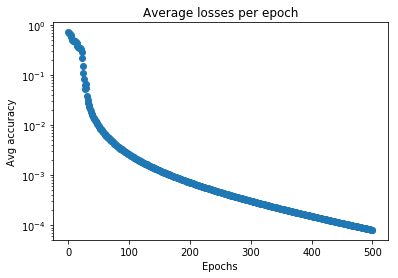

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')  # show average losses
plt.title("Average losses per epoch")
plt.xlabel("Epochs")
plt.ylabel("Avg accuracy")
plt.yscale('log')
plt.show()
plt.close()

## Evaluate the NN

In [57]:
# find predictions on test set

nn_binary_classifier.eval()  # set to eval mode, i.e. deactivate dropout, etc.
x_test = Variable(torch.from_numpy(np.array(x_test, dtype=np.float32)))
pred = nn_binary_classifier(x_test)

acc = 0
for i in range(len(y_test)):
    if round(pred[i]) == y_test[i][0]:
        acc += 1

print("Validation Accuracy: {0:.2f}".format(float(acc)/float(len(y_test))))
for i in range(len(x_test)):
    print("{}:  \t(Actual, Prediction): ({}, {})".format([int(x_test[i][0]),(int(x_test[i][1]))], y_test[i][0], int(round(pred[i][0]))))

print("\nEvaluation complete!")

Validation Accuracy: 1.00
[-4, 7]:  	(Actual, Prediction): (1, 1)
[5, 9]:  	(Actual, Prediction): (0, 0)
[-2, 2]:  	(Actual, Prediction): (1, 1)
[-4, -5]:  	(Actual, Prediction): (0, 0)
[8, 7]:  	(Actual, Prediction): (0, 0)
[10, 9]:  	(Actual, Prediction): (0, 0)
[2, 0]:  	(Actual, Prediction): (1, 1)
[5, -1]:  	(Actual, Prediction): (1, 1)
[-1, 4]:  	(Actual, Prediction): (1, 1)
[-6, -10]:  	(Actual, Prediction): (0, 0)
[-5, 6]:  	(Actual, Prediction): (1, 1)
[8, -6]:  	(Actual, Prediction): (1, 1)
[9, -4]:  	(Actual, Prediction): (1, 1)
[-6, -3]:  	(Actual, Prediction): (0, 0)
[-7, 9]:  	(Actual, Prediction): (1, 1)
[2, 5]:  	(Actual, Prediction): (0, 0)
[-5, 4]:  	(Actual, Prediction): (1, 1)
[7, -9]:  	(Actual, Prediction): (1, 1)
[3, 8]:  	(Actual, Prediction): (0, 0)
[-8, 5]:  	(Actual, Prediction): (1, 1)
[5, -4]:  	(Actual, Prediction): (1, 1)
[2, -5]:  	(Actual, Prediction): (1, 1)
[8, 5]:  	(Actual, Prediction): (0, 0)
[-8, -10]:  	(Actual, Prediction): (0, 0)
[-5, -10]:  	(

## Plot prediction of NN on all data   

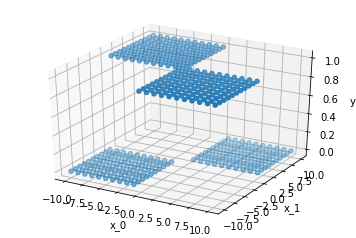

In [58]:
x_all = [e[0] for e in all_data]
x_test = Variable(torch.from_numpy(np.array(x_all, dtype=np.float32)))
pred = nn_binary_classifier(x_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([e[0][0] for e in all_data], [e[0][1] for e in all_data], [e.data.numpy()[0] for e in pred])
ax.set_xlabel('x_0')
ax.set_ylabel('x_1')
ax.set_zlabel('y')

plt.show()
plt.close()